# Pretraining with contractive and margin losses

## 1. Import libraries

In [20]:
import os
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import coma
print(coma.__version__)

2.0.0


In [3]:
from coma.dataset import TrainingSmilesDataset, ValidationSmilesDataset
from coma.vae import SmilesAutoencoder

## 2. Configure GPU (if available)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 3. Set a target property

In [5]:
#PROPERTY_NAME = "drd2" # available only coma==0.1.5
PROPERTY_NAME = "qed"
#PROPERTY_NAME = "logp04"
#PROPERTY_NAME = "logp06"

## 4. Describe file information for inputs

In [6]:
input_dir = os.path.abspath(os.path.join(os.pardir, "data", PROPERTY_NAME))

In [7]:
filepath_train = os.path.join(input_dir, "rdkit_train_triplet.txt")
filepath_valid = os.path.join(input_dir, "rdkit_valid.txt")

## 5. Describe file information for outputs 

In [8]:
output_dir = f"outputs_1_pretraining_{PROPERTY_NAME}"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [9]:
filepath_char2idx      = os.path.join(output_dir, "char2idx.csv")
filepath_configs       = os.path.join(output_dir, "configs.csv")
filepath_checkpoint    = os.path.join(output_dir, "checkpoints.pt")
filepath_history       = os.path.join(output_dir, "history.csv")
filepath_history_valid = os.path.join(output_dir, "history_valid.csv")

## 6. Load datasets (for training and validation)

In [10]:
dataset = TrainingSmilesDataset(filepath_train, device=device)

In [11]:
dataset.save_char2idx(filepath_char2idx)

In [12]:
dataset_valid = ValidationSmilesDataset(filepath_valid, filepath_char2idx, device=device)

## 7. Initialize a generator of COMA

In [13]:
## Model configuration
model_configs = {"hidden_size":128,
                 "latent_size":128,
                 "num_layers" :2,
                 "vocab_size" :dataset.vocab_size,
                 "sos_idx"    :dataset.sos_idx,
                 "eos_idx"    :dataset.eos_idx,
                 "pad_idx"    :dataset.pad_idx,
                 "device"     :device
                }

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Configuration save
generator.save_config(filepath_configs)

## 8. Start to train

In [14]:
help(generator.fit)

Help on method fit in module coma.vae:

fit(dataset, batch_size=100, total_steps=100000, learning_rate=0.001, validation_dataset=None, validation_repetition_size=20, checkpoint_step=1000, checkpoint_filepath=None, display_step=1000, use_contractive=True, use_margin=True, verbose=1) method of coma.vae.SmilesAutoencoder instance



In [15]:
df_history, df_history_valid = generator.fit(dataset, validation_dataset=dataset_valid,
                                             batch_size=100, total_steps=100000, learning_rate=1e-3,
                                             checkpoint_step=5000, checkpoint_filepath=filepath_checkpoint,
                                             display_step=5000, verbose=1)

[00000000/00100000]  loss(tr): 3.336  loss_recon_src(tr): 3.338  loss_recon_tar(tr): 3.337  loss_recon_neg(tr): 3.333  loss_contractive(tr): 0.491  loss_margin(tr): 1.964  beta: 0.000  gamma: 0.000  valid_ratio(va): 0.139  similarity(va): 0.004
[00005000/00100000]  loss(tr): 0.438  loss_recon_src(tr): 0.329  loss_recon_tar(tr): 0.235  loss_recon_neg(tr): 0.302  loss_contractive(tr): 1.070  loss_margin(tr): 0.407  beta: 0.100  gamma: 0.100  valid_ratio(va): 1.000  similarity(va): 0.224
[00010000/00100000]  loss(tr): 0.416  loss_recon_src(tr): 0.239  loss_recon_tar(tr): 0.138  loss_recon_neg(tr): 0.189  loss_contractive(tr): 0.784  loss_margin(tr): 0.356  beta: 0.200  gamma: 0.200  valid_ratio(va): 0.997  similarity(va): 0.289
[00015000/00100000]  loss(tr): 0.480  loss_recon_src(tr): 0.197  loss_recon_tar(tr): 0.108  loss_recon_neg(tr): 0.128  loss_contractive(tr): 0.747  loss_margin(tr): 0.380  beta: 0.300  gamma: 0.300  valid_ratio(va): 1.000  similarity(va): 0.308
[00020000/00100000] 

In [16]:
df_history.to_csv(filepath_history, index=False)
df_history_valid.to_csv(filepath_history_valid, index=False)

## 9. Visualize for loss analysis

In [21]:
sns.set_theme(style='whitegrid')

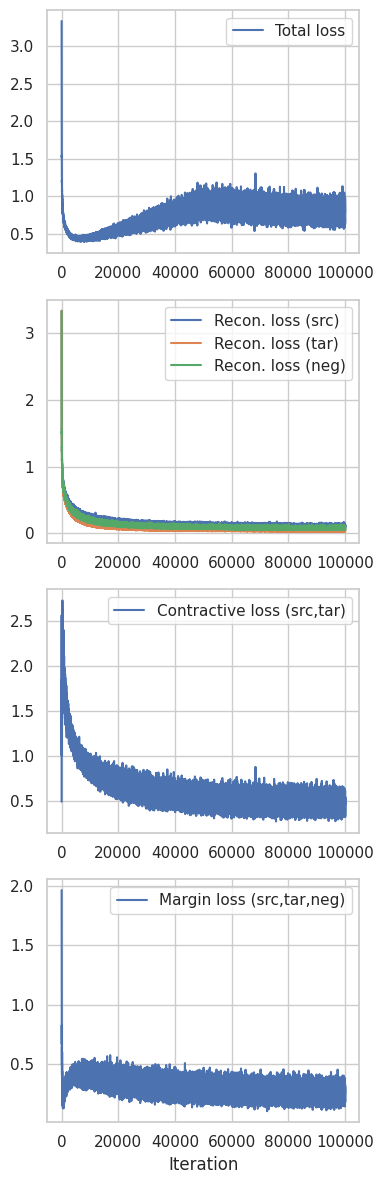

In [22]:
fig, axes = plt.subplots(4,1,figsize=(4,12))

axes[0].plot(df_history.loc[:,"LOSS_TOTAL"], label="Total loss")
axes[1].plot(df_history.loc[:,"LOSS_RECONSTRUCTION_SOURCE"], label="Recon. loss (src)")
axes[1].plot(df_history.loc[:,"LOSS_RECONSTRUCTION_TARGET"], label="Recon. loss (tar)")
axes[1].plot(df_history.loc[:,"LOSS_RECONSTRUCTION_NEGATIVE"], label="Recon. loss (neg)")
axes[2].plot(df_history.loc[:,"LOSS_CONTRACTIVE"], label="Contractive loss (src,tar)")
axes[3].plot(df_history.loc[:,"LOSS_MARGIN"], label="Margin loss (src,tar,neg)")

axes[3].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

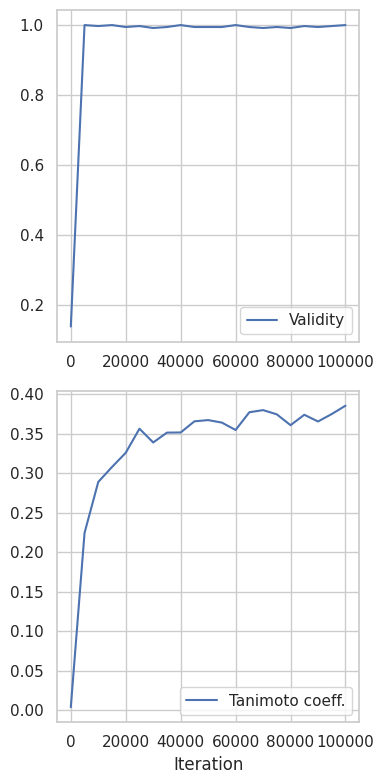

In [24]:
fig, axes = plt.subplots(2,1,figsize=(4,8))

axes[0].plot(df_history_valid.loc[:,"VALID_RATIO"], label="Validity")
axes[1].plot(df_history_valid.loc[:,"AVERAGE_SIMILARITY"], label="Tanimoto coeff.")

axes[1].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()